In [1]:
"""
=======================================================================================
# This code runs with model.py, and process Video_16_3_2.mp4 with GT+Pred bounding box;
# Originally adapted in March, modified in Sep.
- Draw boxes
- Model deplyment
- Video Generation
LOG: Sep. 26th we're testing the baseline with EAST model, test it on ICDAR 2013
LOG: Oct. 7th reuse it on ICDAR 2015 to compare results 
=======================================================================================
"""
import cv2
import os
import time
import datetime
import numpy as np
import uuid
import json
import functools
import logging
import collections
import argparse
import matplotlib
matplotlib.use('Agg')
import tensorflow as tf

import _init_paths
from model import model_flow_east
from model import model
from utils.icdar import restore_rectangle
import lanms
from utils.eval import resize_image, sort_poly, detect
from utils.icdar import load_annotations_solo, check_and_validate_polys
from utils.nms_highlevel import intersection
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [2]:
# used for iou searching and selecting TP, FP, FN #
def eval_single_frame(target, box):
    """
    input params:
        target, python ordered dict
        box, sorted boxes dict from predictions
    """
    TP   = 0
    FP   = 0
    FN   = 0
    precision = 0
    recall = 0
    F_measure = 0
    if not len(box['text_lines']) == 0:
        for t in target:
            d = np.array(t, dtype='int32')
            is_best = 0
            for m in box['text_lines']:
                n = np.array([m['x0'], m['y0'], m['x1'], m['y1'], m['x2'],
                              m['y2'], m['x3'], m['y3']], dtype='int32')

                # pick out the best match
                iou = intersection(n, d)
                if iou>is_best:
                    is_best = iou
            if is_best > 0.5:
                TP = TP+1
            elif is_best == 0:
                FN = FN +1
            else:
                FP = FP+1
        if TP > 0:
            precision = TP/(TP+FP)
            recall    = TP/(TP+FN)
            F_measure = 2*precision*recall/(precision+recall)
    return precision, recall, F_measure


def draw_illu(illu, rst):
    for t in rst['text_lines']:
        d = np.array([t['x0'], t['y0'], t['x1'], t['y1'], t['x2'],
                      t['y2'], t['x3'], t['y3']], dtype='int32')
        d = d.reshape(-1, 2)
        cv2.polylines(illu, [d], isClosed=True, thickness=2, color=(255, 0, 0))
    return illu


def draw_illu_gt(illu, rst, p, r, f):
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.3
    fontColor = (255, 255, 255)
    lineType = 1
    infos = 'Precision ' + str(p)+ ', recall ' + str(r) + ', F_measure ' + str(f)
    cv2.putText(illu, infos,
                (2, 20),
                font,
                0.5,
                (255, 0, 0),
                lineType)
    for t in rst:
        d1 = t.reshape(-1, 2).astype(np.int32)
        cv2.polylines(illu, [d1], isClosed=True, thickness=2, color=(255, 0, 0))
        # bottomLeftCornerOfText = (int(t['x0']), int(t['y0']))

    return illu

In [3]:
video_set = []
test_data_path = '/work/cascades/lxiaol9/ARC/EAST/data/ICDAR2013/test/'
for root, dirs, files in os.walk(test_data_path):
    for file in files:
        if file.endswith('.mp4'):
            video_set.append(os.path.splitext(file)[0])
print(video_set)

['Video_39_2_3', 'Video_48_6_4', 'Video_5_3_2', 'Video_17_3_1', 'Video_35_2_3', 'Video_6_3_2', 'Video_11_4_1', 'Video_20_5_1', 'Video_49_6_4', 'Video_23_5_2', 'Video_44_6_4', 'Video_32_2_3', 'Video_53_7_4', 'Video_24_5_2', 'Video_1_1_2']


resnet_v1_50/block1 (1, 64, 64, 256)
resnet_v1_50/block2 (1, 32, 32, 512)
resnet_v1_50/block3 (1, 16, 16, 1024)
resnet_v1_50/block4 (1, 16, 16, 2048)
Shape of f_0 (1, 16, 16, 2048)
Shape of f_1 (1, 32, 32, 512)
Shape of f_2 (1, 64, 64, 256)
Shape of f_3 (1, 128, 128, 64)
Shape of h_0 (1, 16, 16, 2048), g_0 (1, 32, 32, 2048)
Shape of h_1 (1, 32, 32, 128), g_1 (1, 64, 64, 128)
Shape of h_2 (1, 64, 64, 64), g_2 (1, 128, 128, 64)
Shape of h_3 (1, 128, 128, 32), g_3 (1, 128, 128, 32)
Loading model checkpoint /work/cascades/lxiaol9/ARC/EAST/checkpoints/east/20180921-173054/model.ckpt-56092 for eval or testing...

INFO:tensorflow:Restoring parameters from /work/cascades/lxiaol9/ARC/EAST/checkpoints/east/20180921-173054/model.ckpt-56092
... model loaded
[]
resnet_v1_50/block1 (?, ?, ?, 256)
resnet_v1_50/block2 (?, ?, ?, 512)
resnet_v1_50/block3 (?, ?, ?, 1024)
resnet_v1_50/block4 (?, ?, ?, 2048)
Shape of f_0 (?, ?, ?, 2048)
Shape of f_1 (?, ?, ?, 512)
Shape of f_2 (?, ?, ?, 256)
Shape of f_3 (

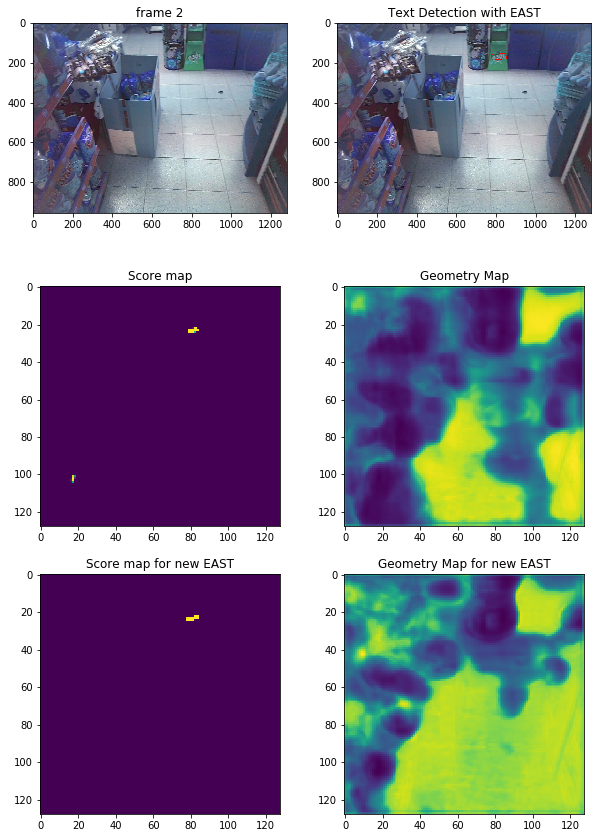

Processing 3 frame for Video_17_3_1 video with  (960, 1280, 3)
24 text boxes before nms, 2 text boxes after nms
> <ipython-input-4-630384e1a570>(136)main()
-> import pdb;pdb.set_trace()
(Pdb) c


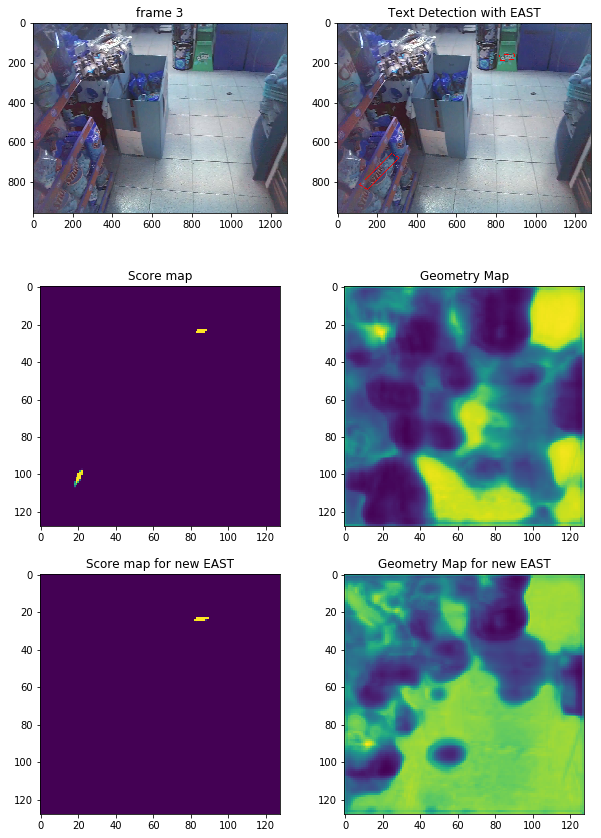

Processing 4 frame for Video_17_3_1 video with  (960, 1280, 3)
33 text boxes before nms, 2 text boxes after nms
> <ipython-input-4-630384e1a570>(137)main()
-> if vis_flag:
(Pdb) 
(Pdb) 
(Pdb) cv
*** NameError: name 'cv' is not defined
(Pdb) c


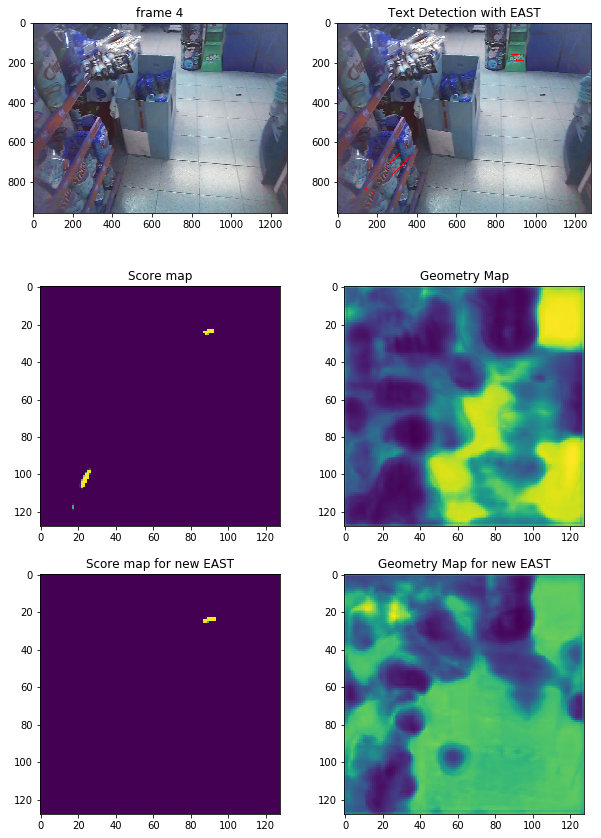

Processing 5 frame for Video_17_3_1 video with  (960, 1280, 3)
17 text boxes before nms, 1 text boxes after nms
> <ipython-input-4-630384e1a570>(136)main()
-> import pdb;pdb.set_trace()


In [ ]:
%matplotlib inline
tf.app.flags.DEFINE_string('f', '', 'kernel')
def main():
    #>>>>>>>>>>>>>>>>>>>>>   1. define data/model path      >>>>>>>>>>>>>>>>>>>>>#
    test_data_path = '/work/cascades/lxiaol9/ARC/EAST/data/ICDAR2013/test/'
    save_path = '/work/cascades/lxiaol9/ARC/EAST/data/ICDAR2013/test_results/'
    checkpoint_path = '/work/cascades/lxiaol9/ARC/EAST/checkpoints/east/'
    idname1 = '20180921-173054'
    idname2 = 'model.ckpt-56092'
    index = range(1, len(video_set))
    vis_flag = True
    idx = 0  # initial frame number
    model_path = checkpoint_path + idname1 + '/' + idname2
    #>>>>>>>>>>>>>>>>>>>>>>>>>>>>> EAST model options >>>>>>>>>>>>>>>>>>>>>>>>>>
    east_opts = {
    'verbose': True,
    'ckpt_path': model_path,
    'batch_size_per_gpu': 1,
    'gpu_devices': ['/device:GPU:1'],
    'controller': '/device:CPU:0',
    'x_dtype': tf.float32,  # image pairs input type
    'x_shape': [512, 512, 3],  # image pairs input shape [2, H, W, 3]
    'y_score_shape': [128, 128, 1],  # u,v flows output type
    'y_geometry_shape': [128, 128, 5],  # u,v flows output shape [H, W, 2]
    'x_mask_shape': [128, 128, 1]
    }
    if not os.path.exists(checkpoint_path):
        raise RuntimeError(
            'Checkpoint `{}` not found'.format(checkpoint_path))
    logger.info('loading model')
    #>>>>>>>>>>>>>>>>>>>>>>>   2. Loading Model        >>>>>>>>>>>>>>>>>>>>>>>>>#
        # 2. for EAST model 
    east_net = model_flow_east.EAST(mode='val', options=east_opts)
    with east_net.graph.as_default():
        print([op.name for op in tf.get_default_graph().get_operations() if op.op_def and op.op_def.name=='Variable'])
    gpu_options = tf.GPUOptions(allow_growth=True)
    input_images = tf.placeholder(tf.float32, shape=[None, None, None, 3], name='input_images')
    global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)
    f_score, f_geometry, _ = model.model(input_images, is_training=False)
    variable_averages = tf.train.ExponentialMovingAverage(0.997, global_step)
    saver = tf.train.Saver(variable_averages.variables_to_restore())
    #>>>>>>>>>>>>>>>>>>>>>>>>  3. restore the model from weights  >>>>>>>>>>>>>#
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    
    logger.info('Restore from {}'.format(model_path))
    saver.restore(sess, model_path)
    print([op.name for op in tf.get_default_graph().get_operations() if op.op_def and op.op_def.name=='Variable'])
    #>>>>>>>>>>>>>>>>>>>>>>    3. Start evaluation      >>>>>>>>>>>>>>>>>>>>>>>>>#
    P_test = []
    R_test = []
    f1_test = []
    for k in index[2:3]:
        P_video = []
        R_video = []
        f1_video = []
        video_save = save_path + video_set[k] + idname1 + '_' + idname2 + '.avi'
        t_start = time.time()
        xml_solo_path = test_data_path + video_set[k]
        raw_video_path = test_data_path + video_set[k]+'.mp4'
        cap = cv2.VideoCapture(raw_video_path)
        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        cnt_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        out = cv2.VideoWriter(video_save, cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
        # 1. load both polys and tags; 2. generate geo maps(the format of polys and tags need to match)
        polys_array_list, tags_array_list, id_list_list, frame_num = load_annotations_solo(xml_solo_path, \
                    1, cnt_frame, frame_width, frame_height)
        #>>>>>>>>>>>>>>>>>>>>>>>>   4. loop over frames   >>>>>>>>>>>>>>>>>>#
        for m in range(2, cnt_frame):
            cap.set(1, m)
            ret, frame = cap.read()
            text_polys, text_tags = polys_array_list[m], tags_array_list[m]
            text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (frame_height, frame_width))
            if text_polys.shape[0] == 0:
                continue
            if ret == True:
                print('Processing %d frame for %s video with '%(m, video_set[k]), frame.shape)
                start_time = time.time()
                img = frame
                rtparams = collections.OrderedDict()
                rtparams['start_time'] = datetime.datetime.now().isoformat()
                rtparams['image_size'] = '{}x{}'.format(img.shape[1], img.shape[0])
                timer = collections.OrderedDict([
                    ('net', 0),
                    ('restore', 0),
                    ('nms', 0)
                ])
                im_resized = cv2.resize(frame, (int(512), int(512)))
                ratio_h, ratio_w = 512/frame_height, 512/frame_width
                rtparams['working_size'] = '{}x{}'.format(
                    im_resized.shape[1], im_resized.shape[0])
                start = time.time()
                score, geometry = sess.run(
                    [f_score, f_geometry],
                    feed_dict={input_images: [im_resized[:,:,::-1]]})
                east_val = east_net.sess.run([east_net.y_hat_val_tnsr], feed_dict={east_net.x_tnsr:[im_resized[:,:,::-1]]})
                score_map_east, geo_map_east, feature = east_val[0][0],  east_val[0][1],  east_val[0][2]
                timer['net'] = time.time() - start
                boxes, timer = detect(score_map=score, geo_map=geometry, timer=timer)
                logger.info('net {:.0f}ms, restore {:.0f}ms, nms {:.0f}ms'.format(
                    timer['net']*1000, timer['restore']*1000, timer['nms']*1000))
                if boxes is not None:
                    scores = boxes[:,8].reshape(-1)
                    boxes = boxes[:, :8].reshape((-1, 4, 2))
                    boxes[:, :, 0] /= ratio_w
                    boxes[:, :, 1] /= ratio_h
                duration = time.time() - start_time
                timer['overall'] = duration
                logger.info('[timing] {}'.format(duration))
                text_lines = []
                if boxes is not None:
                    text_lines = []
                    for box, score_new in zip(boxes, scores):
                        box = sort_poly(box.astype(np.int32))
                        if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3]-box[0]) < 5:
                            continue
                        tl = collections.OrderedDict(zip(
                            ['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3'],
                            map(float, box.flatten())))
                        tl['score'] = float(score_new)
                        text_lines.append(tl)
                pred = {
                    'text_lines': text_lines,
                    'rtparams': rtparams,
                    'timing': timer,
                }
                new_img = draw_illu(img.copy(), pred)
                out.write(new_img)
                #>>>>>>>>>>>>>>>>>>>>>>>>  5. Run Visualization & Save  >>>>>>>>>>>>>>>>>>>>>>#
                targets = text_polys
                precision, recall, f1 = eval_single_frame(targets, pred)
                P_video.append(precision)
                R_video.append(recall)
                f1_video.append(f1)
#                 new_img1 = draw_illu_gt(new_img.copy(), targets, precision, recall, f1)
                import pdb;pdb.set_trace()
                if vis_flag:
#                     import pdb; pdb.set_trace()
                    fig1 = plt.figure(figsize=(10, 15))
                    fig1.add_subplot(3, 2, 1)
                    plt.imshow(img)
                    plt.title("frame {}".format(m))
                    fig1.add_subplot(3, 2, 2)
                    plt.imshow(new_img)
                    plt.title('Text Detection with EAST')
                    fig1.add_subplot(3, 2, 3)
                    plt.imshow((np.squeeze(score*255)).astype(np.uint8))
                    plt.title('Score map')
                    fig1.add_subplot(3, 2, 4)
                    plt.imshow(geometry[0, :,:,1])
                    plt.title('Geometry Map')  
                    fig1.add_subplot(3, 2, 5)
                    plt.imshow((np.squeeze(score_map_east*255)).astype(np.uint8))
                    plt.title('Score map for new EAST')
                    fig1.add_subplot(3, 2, 6)
                    plt.imshow(geo_map_east[0, :,:,1])
                    plt.title('Geometry Map for new EAST')                   
                    plt.show()
                    fig1.savefig(save_path+"frame" + str(m) + ".png", dpi=500)
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
                # time.sleep(.100)
            else:
                break
            # evaluation on ret and gt
        P_test.append(np.array(P_video, dtype=np.float32))
        R_test.append(np.array(R_video, dtype=np.float32))
        f1_test.append(np.array(f1_video, dtype=np.float32))
        print(P_video)
        print(R_video)
        print(f1_video)
        print("testing results are P:{}, R:{}, F1:{} on ".format(sum(P_video)/cnt_frame, sum(R_video)/cnt_frame, sum(f1_video)/cnt_frame)+video_set[k])
        cap.release()
        out.release()
        cv2.destroyAllWindows()
    print('here is the precision')
    for item in P_test:
        print(np.mean(item))
    print('here is the recall')
    for item in R_test:
        print(np.mean(item))
    print('here is the f-score')
    for item in f1_test:
        print(np.mean(item))
    print(video_set)
if __name__ == '__main__':
    main()